In [116]:
# environment name is ="fraud_detection"

# Data handling
import pandas as pd
import numpy as np
import threadpoolctl
# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
import matplotlib.pyplot as plt

# EDA (pandas-profiling, etc. )

# Statistics
from scipy import stats

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from collections import Counter

# balance data
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans



# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Evaluations
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from statistics import stdev
from sklearn.model_selection import KFold

# Other packages
import os, pickle

import warnings
warnings.filterwarnings("ignore")



# used this https://medium.com/@emmanuel.ikogho/how-to-detect-fraud-with-machine-learning-cc80d27949e4 article for this project

In [58]:

# Step 1: Define the file path using a raw string
file_path = 'Fraud.csv'

# Step 2: Load the Dataset
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Exploratory Data Analysis

In [59]:
data.rename(columns={
    'step': 'time_step',
    'type': 'trans_type',
    'amount': 'trans_amt',
    'nameOrig': 'cust_orig',
    'oldbalanceOrg': 'old_orig_bal',
    'newbalanceOrig': 'new_orig_bal',
    'nameDest': 'cust_dest',
    'oldbalanceDest': 'old_dest_bal',
    'newbalanceDest': 'new_dest_bal'
}, inplace=True)
data.head()

,time_step,trans_type,trans_amt,cust_orig,old_orig_bal,new_orig_bal,cust_dest,old_dest_bal,new_dest_bal,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [60]:
data['isMerchant'] = data['cust_dest'].apply(lambda x: 1 if x.startswith('M') else 0)

In [61]:
data.shape

(6362620, 12)

In [62]:
# summary of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   time_step       int64  
 1   trans_type      object 
 2   trans_amt       float64
 3   cust_orig       object 
 4   old_orig_bal    float64
 5   new_orig_bal    float64
 6   cust_dest       object 
 7   old_dest_bal    float64
 8   new_dest_bal    float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
 11  isMerchant      int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 582.5+ MB


In [63]:
for col in data.columns:
    if data[col].dtype == 'object':
        print(col, data[col].nunique())

trans_type 5
cust_orig 6353307
cust_dest 2722362


In [64]:
data.drop(columns=['cust_orig', 'cust_dest'], inplace=True)

In [65]:
data.describe()

,time_step,trans_amt,old_orig_bal,new_orig_bal,old_dest_bal,new_dest_bal,isFraud,isFlaggedFraud,isMerchant
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06,3.381461e-01
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03,4.730786e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00,1.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00,1.000000e+00


In [66]:
# Check of outliers by applying the IQR method checking
df = data.drop(['trans_type', 'time_step', 'isFraud', 'isFlaggedFraud', 'isMerchant'], axis=1)

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3-Q1
IQR
((df < (Q1-1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any()

trans_amt       True
old_orig_bal    True
new_orig_bal    True
old_dest_bal    True
new_dest_bal    True
dtype: bool

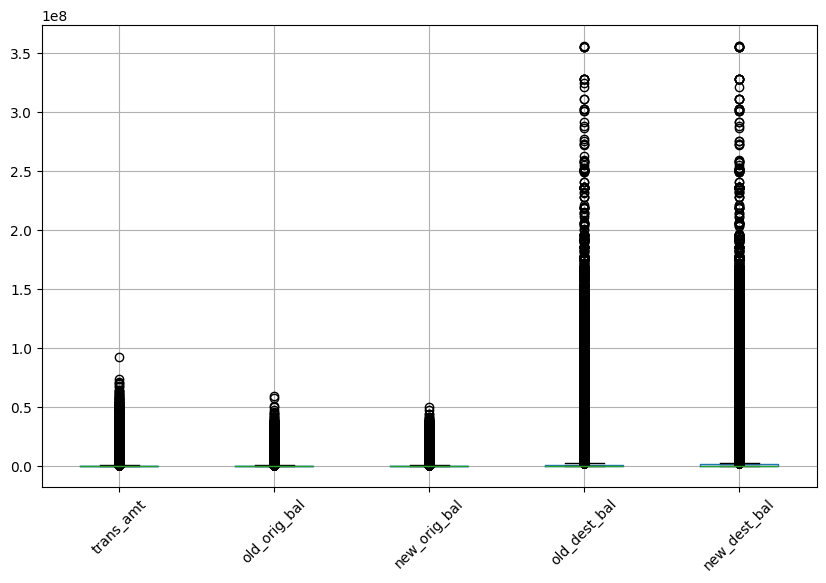

In [67]:
plt.figure(figsize=(10, 6))

# Plot the boxplot
df.boxplot()

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [68]:
# Check if outliers still exist in the columns
outliers_exist = False

for col in df.columns.tolist():
    # Calculate the first and third quartiles (Q1 and Q3)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Modify the values in the col to be within the range
    df[col] = df[col].clip(lower_bound, upper_bound)

    # Check if outliers exist in the col
    if (df[col] < lower_bound).any() or (df[col] > upper_bound).any():
        outliers_exist = True
        print(f"Outliers still exist in '{col}'.")

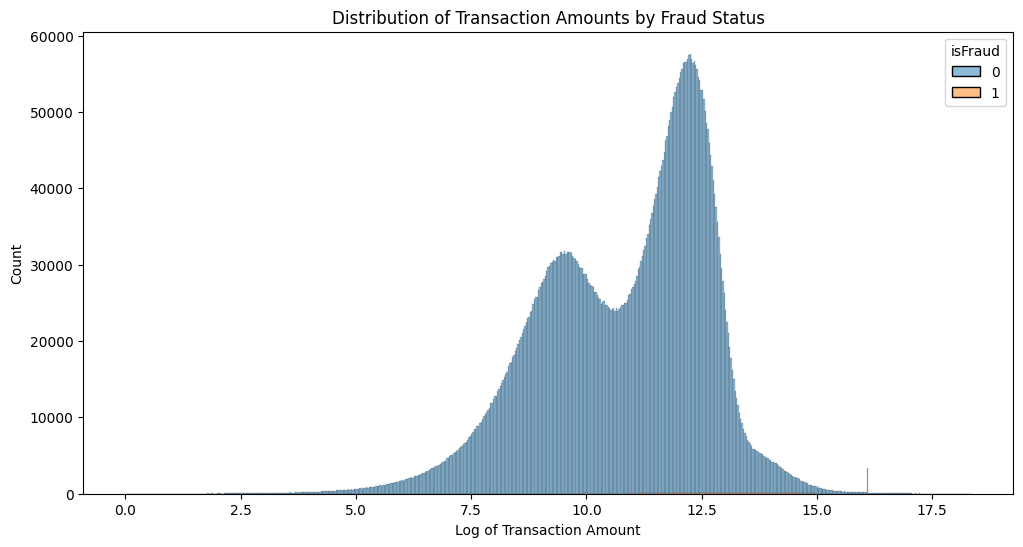

In [69]:
# Apply logarithmic transformation to 'trans_amt' to handle skewness
df = data
df['log_trans_amt'] = np.log1p(df['trans_amt'])  # Using log1p to avoid log(0)

# Create a plot with the transformed data
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='log_trans_amt', hue='isFraud', multiple='stack', alpha=0.5)
plt.xlabel('Log of Transaction Amount')
plt.ylabel('Count')
plt.title('Distribution of Transaction Amounts by Fraud Status')
plt.show()
data.drop('log_trans_amt', axis=1, inplace=True)

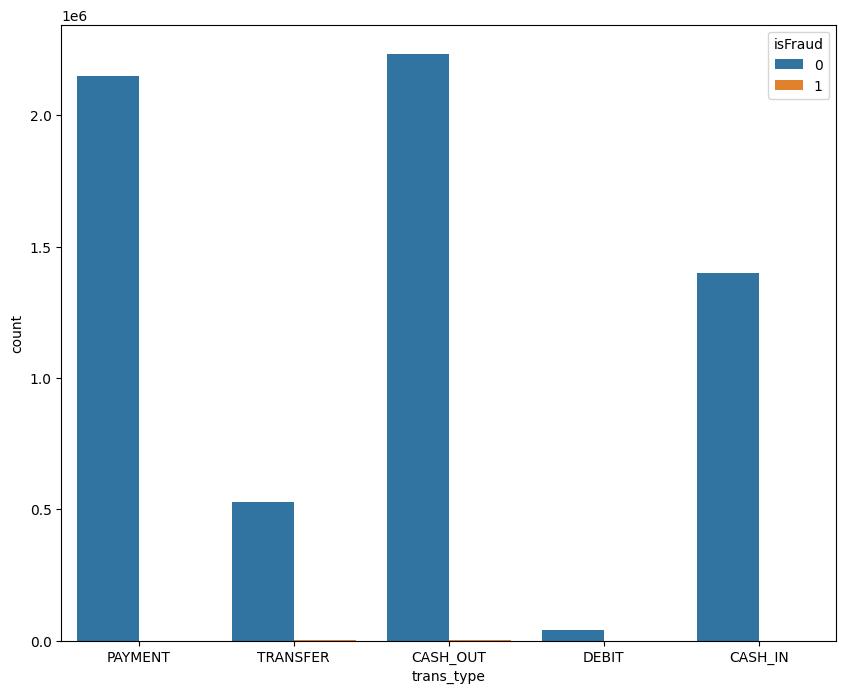

In [70]:
fig = plt.figure(figsize= (10,8))

sns.countplot(data = data,
              x = 'trans_type',
              hue = 'isFraud')
plt.show()

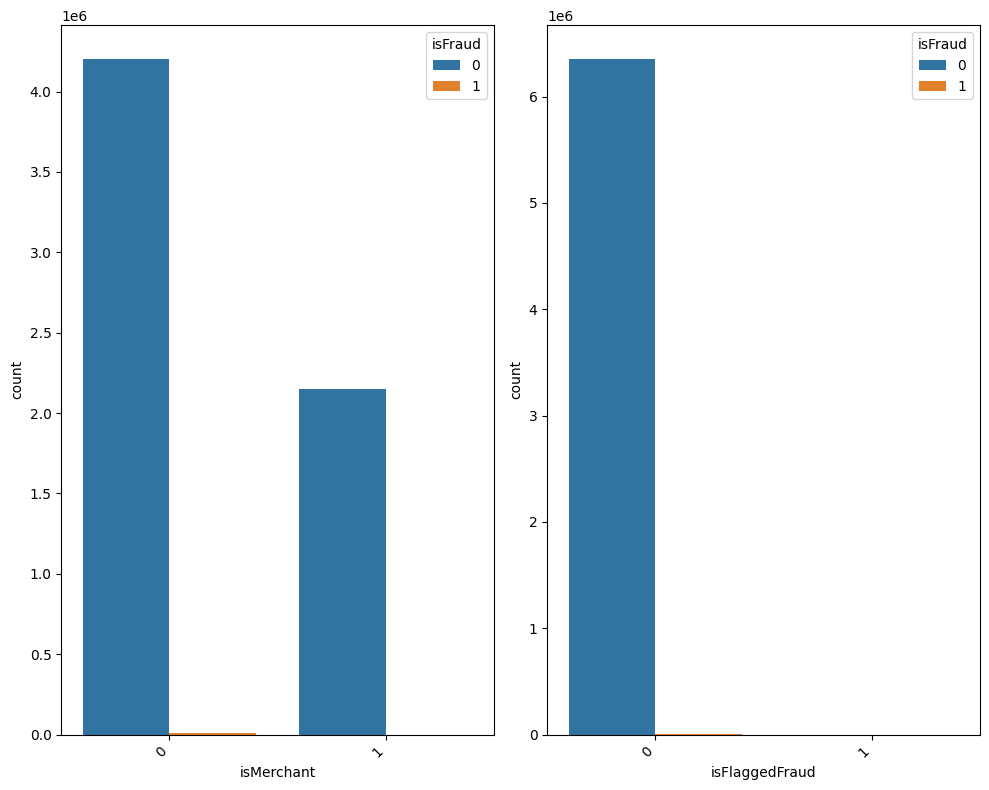

In [71]:
# Setup figure
cols = 2
rows = 1
fig = plt.figure(figsize= (10,8))

# Plotting
for i, col in enumerate(['isMerchant', 'isFlaggedFraud']):
    ax=fig.add_subplot(rows, cols, i+1)
    sns.countplot(x=data[col], hue='isFraud', data=data, ax=ax)
    plt.xticks(rotation=45, ha='right')
fig.tight_layout()
plt.show()

In [72]:
numeric = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
numeric.remove('isFraud')
categoric = [col for col in data.columns if data[col].dtype == 'object']

<Axes: >

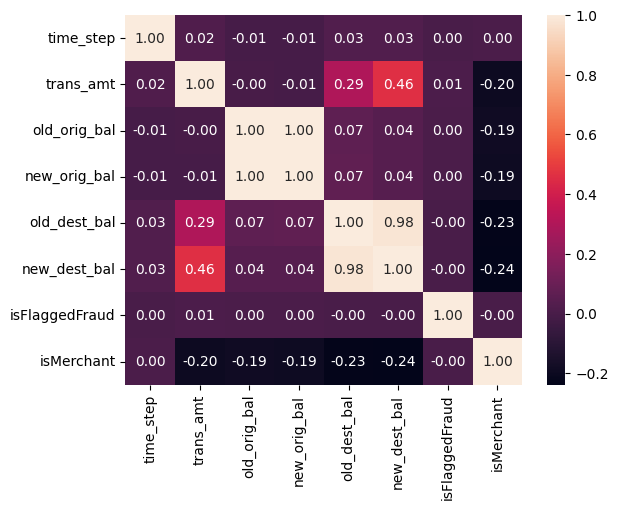

In [73]:
# correlation heatmap df
correlation = data[numeric].corr()
sns.heatmap(correlation, annot=True, fmt='.2f')

In [74]:
# correlation heatmap df
correlation = data[numeric].corr()

# Get column pairs with correlation > 0.5
high_corr_pairs = []
for i in range(len(correlation.columns)):
    for j in range(i+1, len(correlation.columns)):
        if abs(correlation.iloc[i, j]) > 0.5:
            high_corr_pairs.append((correlation.columns[i], correlation.columns[j], correlation.iloc[i, j]))

# Check if there are high correlation pairs
if high_corr_pairs:
    # Print column pairs with correlation > 0.5 and their correlation values
    for pair in high_corr_pairs:
        print(pair[0], "-", pair[1], "Correlation:", pair[2])
else:
    print("No high correlation columns")

old_orig_bal - new_orig_bal Correlation: 0.9988027631723787
old_dest_bal - new_dest_bal Correlation: 0.9765685054474923


In [75]:
# so we will drop one from each pair
data.drop(columns=['old_orig_bal', 'old_dest_bal'], inplace=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_17296\805348303.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y='time_step', palette=color)


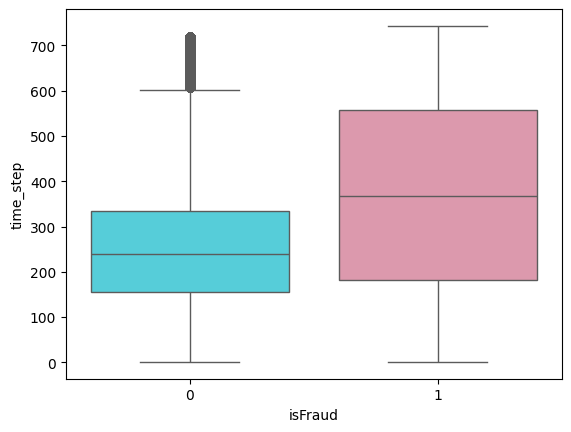

In [76]:
# Define your color palette
color = ['#40DFEF', '#E78EA9']

# Create the box plot
sns.boxplot(data=data, x='isFraud', y='time_step', palette=color)

# Display the plot
plt.show()

D’Agostino’s K^2 Test

In [77]:
# get a list of numerical columns in our dataset
numeric = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]

# loop over each numerical column and test for normality
for col in data[numeric]:
    stat, p = stats.normaltest(data[col])
    # print('Statistics=%.5f, p=%.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        print(f'looks Gaussian (fail to reject H0) for this column: {col}')
    else:
        print(f'does not look Gaussian (reject H0) for this column: {col}')

does not look Gaussian (reject H0) for this column: time_step
does not look Gaussian (reject H0) for this column: trans_amt
does not look Gaussian (reject H0) for this column: new_orig_bal
does not look Gaussian (reject H0) for this column: new_dest_bal
does not look Gaussian (reject H0) for this column: isFraud
does not look Gaussian (reject H0) for this column: isFlaggedFraud
does not look Gaussian (reject H0) for this column: isMerchant


Feature Processing & Engineering

In [78]:
data.shape

(6362620, 8)

In [79]:
data.duplicated().sum()

np.int64(1975)

In [80]:
data['trans_type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [81]:
dup = data.loc[data.duplicated(),:]
dup.head(22)

,time_step,trans_type,trans_amt,new_orig_bal,new_dest_bal,isFraud,isFlaggedFraud,isMerchant
11104,7,PAYMENT,1849.50,0.0,0.0,0,0,1
26143,8,PAYMENT,1433.34,0.0,0.0,0,0,1
33556,8,PAYMENT,7759.31,0.0,0.0,0,0,1
51742,9,PAYMENT,28319.01,0.0,0.0,0,0,1
59969,9,PAYMENT,2388.93,0.0,0.0,0,0,1
60370,9,PAYMENT,12099.17,0.0,0.0,0,0,1
60763,9,PAYMENT,10042.85,0.0,0.0,0,0,1
63096,9,PAYMENT,2783.83,0.0,0.0,0,0,1
66667,9,PAYMENT,9494.15,0.0,0.0,0,0,1
69138,9,PAYMENT,6755.57,0.0,0.0,0,0,1


In [82]:
data.isnull().sum()

time_step         0
trans_type        0
trans_amt         0
new_orig_bal      0
new_dest_bal      0
isFraud           0
isFlaggedFraud    0
isMerchant        0
dtype: int64

In [83]:
# Drop the missing rows
# data = data.dropna()

In [84]:
df = data
X = df.drop('isFraud', axis=1)
y = df['isFraud']

C:\Users\Dell\AppData\Local\Temp\ipykernel_17296\813004662.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data = data,
C:\Users\Dell\AppData\Local\Temp\ipykernel_17296\813004662.py:19: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.countplot(data = data,
C:\Users\Dell\AppData\Local\Temp\ipykernel_17296\813004662.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No Fraud','isFraud'])


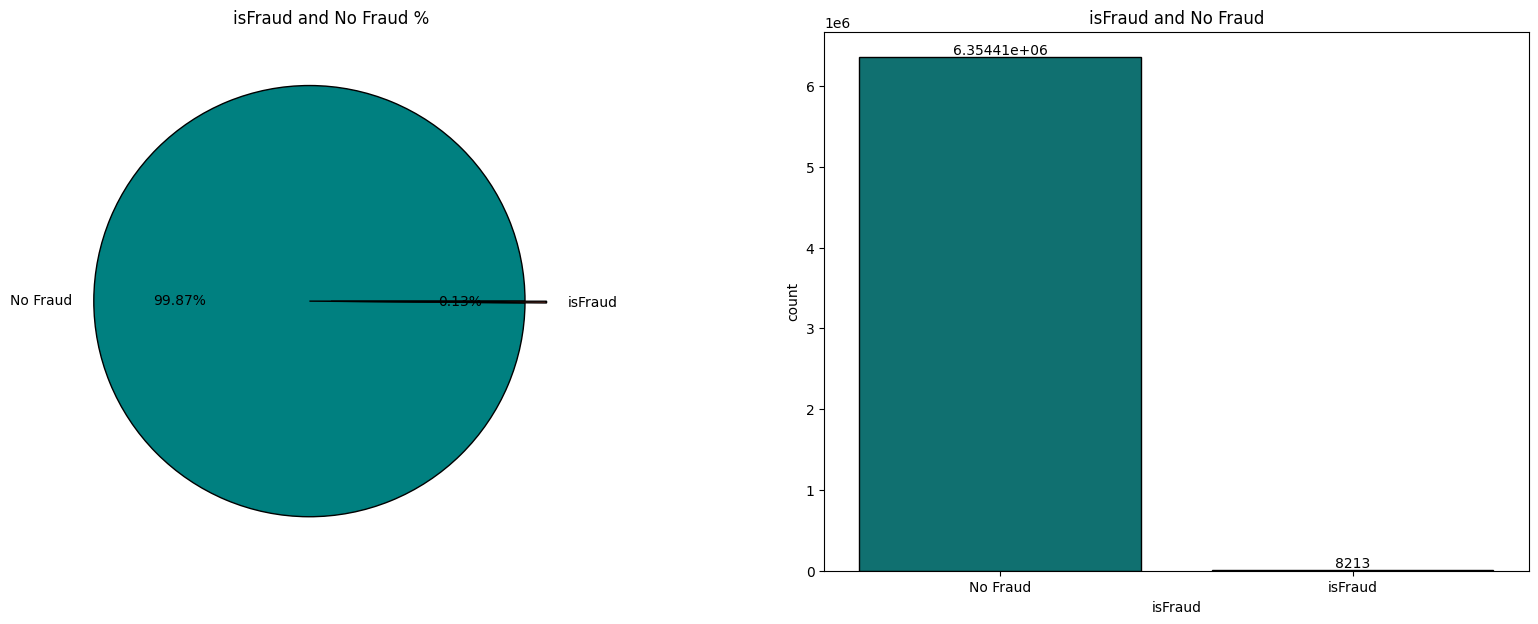

In [85]:
#Defining colors for the plots
palette = ['#008080','#FF6347', '#E50000', '#D2691E']
palette2 = ['#FF6347', '#008080', '#E50000', '#D2691E']

l1 = list(data['isFraud'].value_counts())
pie_values = [l1[0] / sum(l1) * 100, l1[1] / sum(l1) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,7))

plt.subplot(1,2,1)
plt.pie(pie_values,labels = ['No Fraud','isFraud'],
        autopct = '%1.2f%%',
        explode = (0.1,0),
        colors = palette,
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('isFraud and No Fraud %');

plt.subplot(1,2,2)
ax = sns.countplot(data = data,
                   x='isFraud',
                   palette = palette,
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['No Fraud','isFraud'])

plt.title('isFraud and No Fraud')
plt.show()

In [86]:
#Oversampling the minority class (the churn customers)
ros = RandomOverSampler(random_state=0)
X_new,y_new= ros.fit_resample(X, y)
# X_new,y_new= X, y

print("After Random Over Sampling Of Minor Class Total Samples are :", len(y_new))
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))

After Random Over Sampling Of Minor Class Total Samples are : 12708814
Original dataset shape Counter({0: 6354407, 1: 8213})
Resampled dataset shape Counter({0: 6354407, 1: 6354407})


Dataset Splitting

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.20, random_state = 42)

In [91]:
X_train.shape, X_test.shape , y_train.shape, y_test.shape

((10167051, 7), (2541763, 7), (10167051,), (2541763,))

Features Encoding

In [92]:
numeric = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
numeric.remove('isFraud')
print("numeric_cols:", numeric)
print("categoric_cols:", categoric)
categoric = [col for col in data.columns if data[col].dtype == 'object']

numeric_cols: ['time_step', 'trans_amt', 'new_orig_bal', 'new_dest_bal', 'isFlaggedFraud', 'isMerchant']
categoric_cols: ['trans_type']


In [96]:
# calling our encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop="first")
# setting output to DataFrame
encoder.set_output(transform="pandas")
# encoding our data
X_catEncoded_train = encoder.fit_transform(X_train[categoric])
X_catEncoded_test = encoder.transform(X_test[categoric]) # encoding our test data

In [97]:
# Features Scaling
Scaler = StandardScaler().fit(X_train[numeric]).set_output(transform="pandas")



X_numScaled_train = Scaler.transform(X_train[numeric])
X_numScaled_test = Scaler.transform(X_test[numeric])
X_train = pd.concat([X_numScaled_train, X_catEncoded_train], axis=1)
X_test = pd.concat([X_numScaled_test, X_catEncoded_test], axis=1)

Machine Learning Modeling


In [99]:
# 1. Logistic Regression
# Create the Model
model= LogisticRegression()

In [100]:
# Train the Model
model=model.fit(X_train, y_train)

In [101]:
# Predict on the test dataset
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:,1]

In [102]:
# Model Evaluation
r_lgt= recall_score(y_test, pred)
print("recall_score : ", r_lgt)

p_lgt= precision_score(y_test, pred)
print("precision_score :",p_lgt)

f1_lgt= f1_score(y_test, pred)
print("f1_score :", f1_lgt)

f2_lgt = fbeta_score(y_test, pred, beta=2, average='binary')
print("f2_score :", f2_lgt)

A_lgt= accuracy_score(pred, y_test)
print("accuracy_score :",A_lgt)

acu_lgt = roc_auc_score(pred, y_test)
print("ROC_AUC Score:",acu_lgt)

recall_score :  0.8821481345097983
precision_score : 0.8041043464789662
f1_score : 0.8413202141374544
f2_score : 0.8653505057593553
accuracy_score : 0.8336139128628436
ROC_AUC Score: 0.8367872678158828


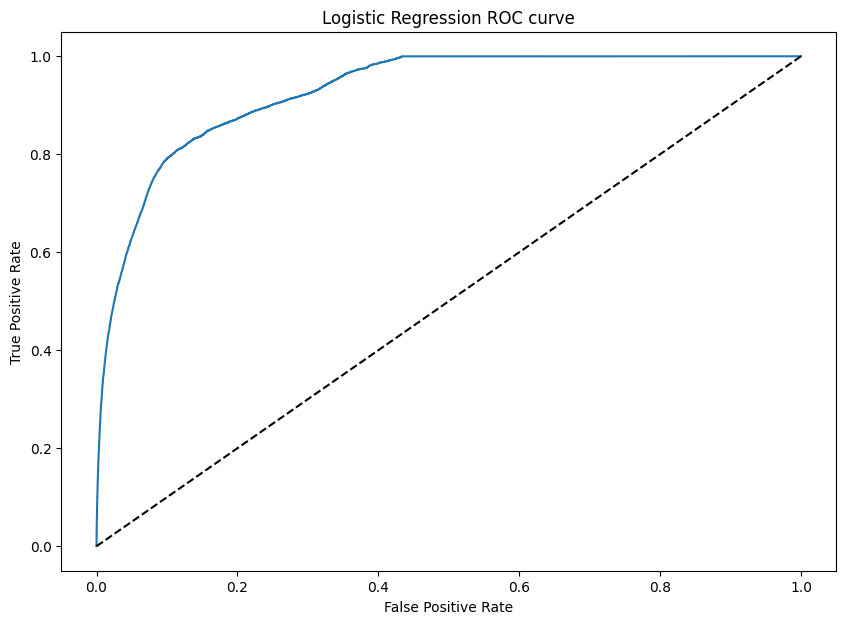

In [103]:
# plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Logistic Regression ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

 XGBoost Classifier

In [104]:
# Create the Model
XG_model= XGBClassifier()

In [105]:
# Train the Model
XG_model= XG_model.fit(X_train, y_train)

In [106]:
# Predict on the test dataset
XG_pred = XG_model.predict(X_test)
XG_prob = XG_model.predict_proba(X_test)[:,1]

In [107]:
# Model Evaluation
r_XG= recall_score(y_test, XG_pred)
print("recall_score : ", r_XG)

p_XG= precision_score(y_test, XG_pred)
print("precision_score :",p_XG)

f1_XG= f1_score(y_test, XG_pred)
print("f1_score :", f1_XG)

f2_XG = fbeta_score(y_test, XG_pred, beta=2, average='binary')
print("f2_score :", f2_XG)


A_XG= accuracy_score( y_test, XG_pred)
print("accuracy_score :",A_XG)

acu_XG = roc_auc_score(XG_pred, y_test)
print("ROC_AUC Score:",acu_XG)

recall_score :  0.9646777231719235
precision_score : 0.9752736020007668
f1_score : 0.9699467256107884
f2_score : 0.9667784397669577
accuracy_score : 0.9701089361990083
ROC_AUC Score: 0.9701642696785007


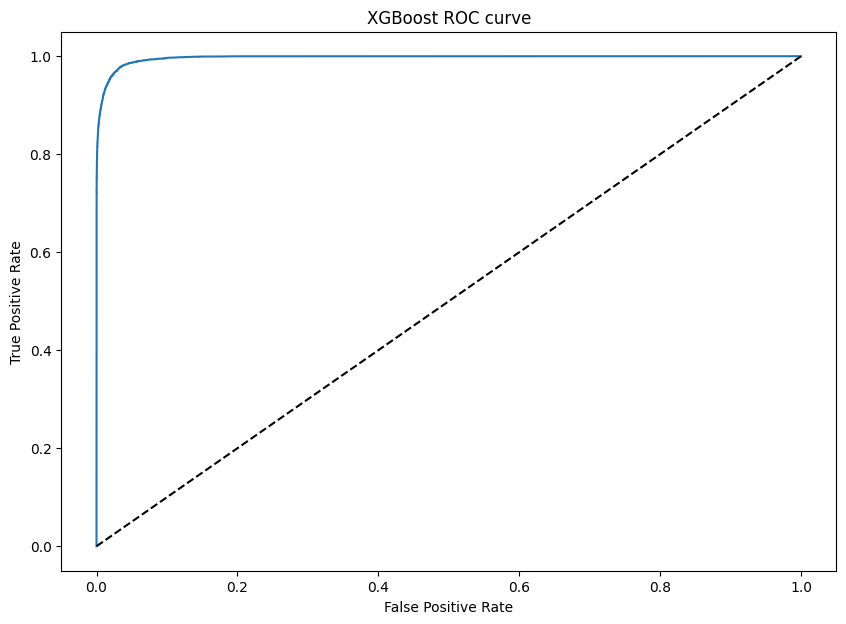

In [108]:
#  plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, XG_prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('XGBoost ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

DecisionTreeClassifier

In [109]:
# Create the Model
dtmodel = DecisionTreeClassifier()

In [110]:
# Train the Model
dtmodel = dtmodel.fit(X_train, y_train)

In [111]:
# Predict on the test dataset
dt_pred = dtmodel.predict(X_test)
dt_prob = dtmodel.predict_proba(X_test)[:,1]

In [112]:
# Model Evaluation
r_dt= recall_score(y_test, dt_pred)
print("recall_score : ", r_dt)

p_dt= precision_score(y_test, dt_pred)
print("precision_score :",p_dt)

f1_dt= f1_score(y_test, dt_pred)
print("f1_score :", f1_dt)

f2_dt = fbeta_score(y_test, dt_pred, beta=2, average='binary')
print("f2_score :", f2_dt)


A_dt= accuracy_score( y_test, dt_pred)
print("accuracy_score :", A_dt)

acu_dt = roc_auc_score(dt_pred, y_test)
print("ROC_AUC Score:",acu_dt)

recall_score :  1.0
precision_score : 0.9996578469844521
f1_score : 0.9998288942200467
f2_score : 0.9999315506607721
accuracy_score : 0.999828858945543
ROC_AUC Score: 0.9998289234922261


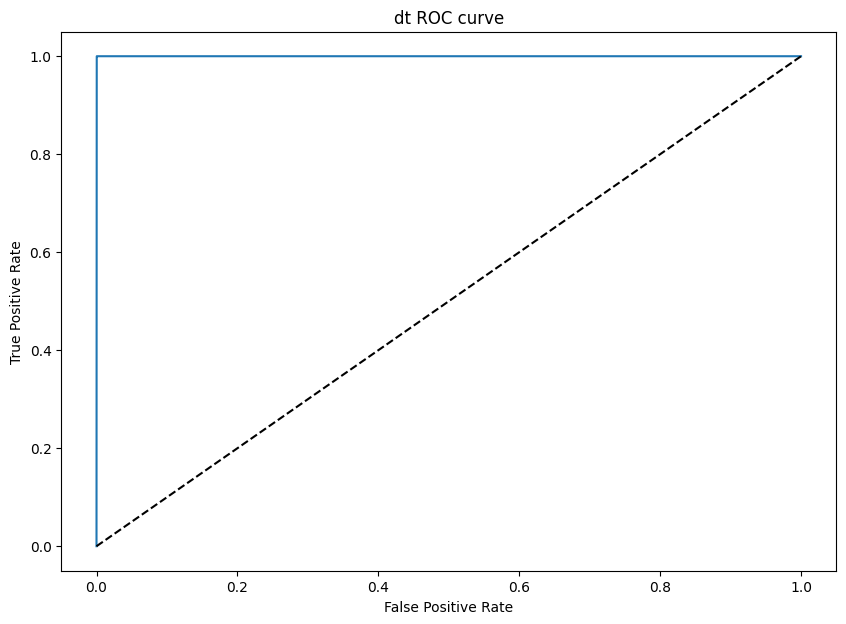

In [113]:
#  plot the model evaluation
fpr, tpr, _ = roc_curve(y_test, dt_prob)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('dt ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr,tpr)
plt.plot((0,1), linestyle="--",color='black')
plt.show()

Models comparison

In [114]:
compare_models = ['Logistic Regression', 'XGBClassifier', 'DecisionTreeClassifier']

data = {
    'Accuracy': [A_lgt, A_XG, A_dt],
    'Recall': [r_lgt, r_XG, r_dt],
    'Precision': [p_lgt, p_XG, p_dt],
    'f1_score': [f1_lgt, f1_XG, f1_dt],
    'f2_score': [f2_lgt, f2_XG, f2_dt],
    'ROC_AUC': [acu_lgt, acu_XG, acu_dt],
    'Description': ['', 'best model', '']
}
result=pd.DataFrame(data=data, index=compare_models)
result

,Accuracy,Recall,Precision,f1_score,f2_score,ROC_AUC,Description
Logistic Regression,0.833614,0.882148,0.804104,0.841320,0.865351,0.836787,
XGBClassifier,0.970109,0.964678,0.975274,0.969947,0.966778,0.970164,best model
DecisionTreeClassifier,0.999829,1.000000,0.999658,0.999829,0.999932,0.999829,


k-Fold cross validation

In [117]:
# decisionTree Classifier (Best Model)
dt_fold = KFold(n_splits = 5,shuffle=True)
# Define custom F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

score = cross_val_score(dtmodel, X_train, y_train, cv=dt_fold, scoring=f2_scorer, error_score="raise")
dt_cv_score = score.mean()
dt_cv_stdev = stdev(score)
print('Cross Validation f2 scores are: {}'.format(score))
print('Average Cross Validation f2 score: ', dt_cv_score)
print('Cross Validation f2 standard deviation: ', dt_cv_stdev)

Cross Validation f2 scores are: [0.99990816 0.99991008 0.99991424 0.99991383 0.99990817]
Average Cross Validation f2 score:  0.999910896080473
Cross Validation f2 standard deviation:  2.9746651504493727e-06


Using Confusion Matrix For Predictions

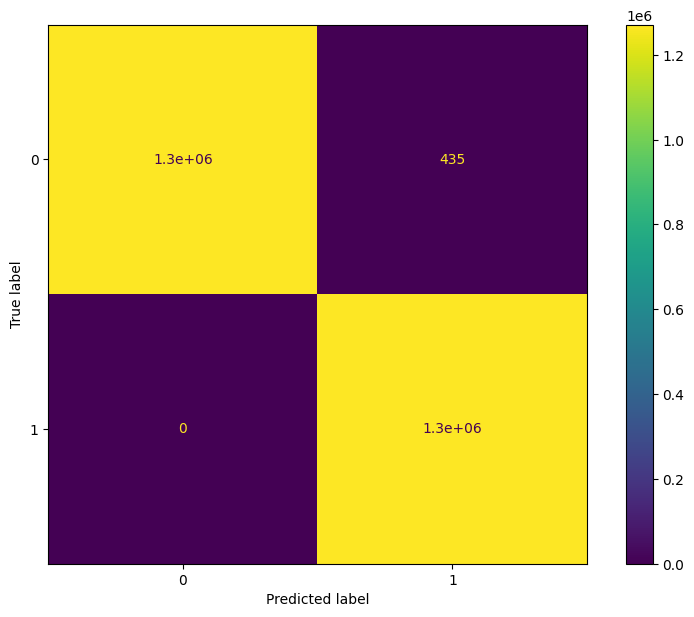

In [118]:
# <!-- DecisionTree Classifier -->
fig, ax = plt.subplots(figsize=(10,7))
y_pred_dt = dtmodel.predict(X_test)

cm = confusion_matrix(y_test, y_pred_dt, labels=dtmodel.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=dtmodel.classes_)
disp.plot(ax=ax)
plt.show()

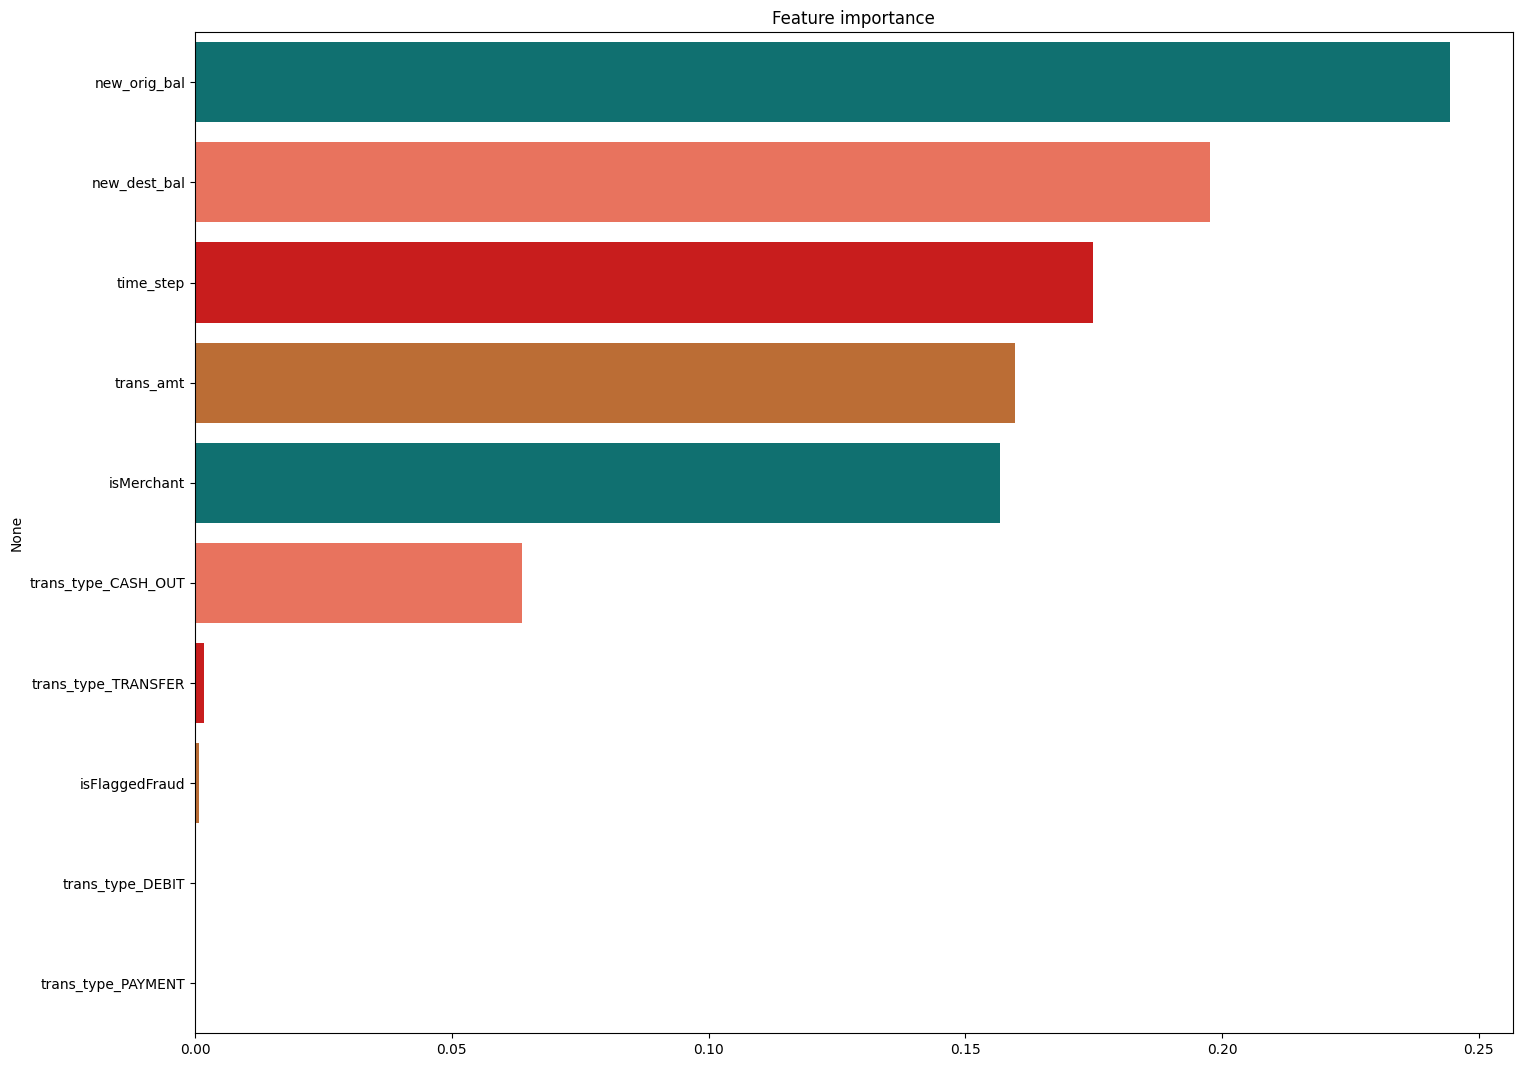

In [119]:
# Feature Importance
# DecisionTreeClassifier
fimp = pd.Series(data=dtmodel.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(17,13))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')